<a href="https://colab.research.google.com/github/SantiagoGC15/Epidemiologic-model/blob/main/El_modelo_epidemiol%C3%B3gico_SIR_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  
import numpy as np
from numpy import exp
from scipy.integrate import odeint

la versión del modelo SIR que analizaremos hay cuatro estados.

Se supone que todos los individuos de la población se encuentran en uno de estos cuatro estados.

Los estados son: susceptible (**S**), expuesto (**E**), infectado (**I**) y eliminado(**R**).

Comentarios:

* Los del estado **R** se han infectado y se han recuperado o han muerto.

* Quienes se han recuperado han adquirido inmunidad.

* Los del grupo expuesto aún no son infecciosos.

El flujo a través de los estados sigue la ruta **S** $\rightarrow$ **E**$\rightarrow$  **I** $\rightarrow$  **R**.

Todos los individuos de la población se infectan eventualmente cuando la tasa de transmisión es positiva $i(0)>0$.

El interés está principalmente en

* la cantidad de infecciones en un momento dado (que determina si el sistema de atención médica está abrumado o no) 

* cuánto tiempo se puede aplazar el número de casos (con suerte hasta que llegue una vacuna)

Usando letras minúsculas para la fracción de la población en cada estado, la dinámica es


$$ \frac{dS}{dt}=-β(t)S(t)I(t) $$
$$ \frac{dI}{dt}=β(t)S(t)I(t)- σ(t)I(t) $$
$$ \frac{dR}{dt}= σ(t)e(t)- γ(t)I(t) $$

Donde
* $β(t)$ se llama velocidad de transmisión (la velocidad a la que los individuos chocan con otros y los exponen al virus).

* $σ$ se llama tasa de infección (la tasa a la que las personas expuestas se infectan)

* $γ$ se denomina tasa de recuperación (la tasa a la que las personas infectadas se recuperan o mueren).

No necesitamos modelar la fracción $r$ de la población $R$ en un estado por separado porque los estados forman una partición.

En particular, la fracción "eliminada" de la población es $r=1-s-e-i$.

También rastrearemos $c=i+r$ el cuál es el número de casos acumulados (es decir, todos aquellos que tienen o han tenido la infección).

**Referencias**
*   M. J. Keeling and P:. Rohani, Modeling Infectious Diseases in Humans and   Animals, Princeton (2007).
*  R. M. Anderson and R. M. May, Infectious Diseases of Humans: Dynamics and Control, OUP (1992).

Para nuestro modelo, ambos $σ$ y $γ$ se consideran parámetros fijos biológicamente determinados.

Como en la nota de Atkeson (https://sites.google.com/site/andyatkeson/home?authuser=0) , establecemos

 * $ σ=1/5.2$ para reflejar un período medio de incubación de 5,2 días.

 * $ γ=1/18$ para que coincida con una duración media de la enfermedad de 18 días.

La tasa de transmisión se modela como 

* $\beta(t):= R(t)γ$ donde $R(t)$ es el número de reproducción efectivo en el tiempo $t$.

In [ ]:
# tamaño de la población para que coincida con los de EE. UU.
N = 3.3e8
γ = 1 / 10
σ = 1 / 5.2

def F(x, t, R0=1.6):
    """
    Derivada temporal del vector de estado.

         * x es el vector de estado (array_like)
         * t es el tiempo (escalar)
         * R0 es la tasa de transmisión efectiva, por defecto a una constante
    """
    s, e, i = x

    # Nueva exposición de susceptibles
    β = R0(t) * γ if callable(R0) else R0 * γ
    ne = β * s * i

    # Derivadas de tiempo
    ds = - ne
    de = ne - σ * e
    di = σ * e - γ * i

    return ds, de, di

# condiciones iniciales de s, e, i
i_0 = 1e-7
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

# En forma vectorial, la condición inicial es
x_0 = s_0, e_0, i_0

# Resolvemos la ruta del tiempo numéricamente usando odeint, en una secuencia de fechas t_vec
def resolver_ruta(R0, t_vec, x_init=x_0):
    """
    Resuelva para i (t) y c(t) mediante integración numérica,
    dado el camino del tiempo para R0.

    """
    G = lambda x, t: F(x, t, R0)
    s_ruta, e_ruta, i_ruta = odeint(G, x_init, t_vec).transpose()

    c_ruta = 1 - s_ruta - e_ruta       # casos acumulativos
    return i_ruta, c_ruta


## Experimentos

realicemos algunos experimentos con este código.

El período de tiempo que investigamos será de 550 días, o alrededor de 18 meses:


In [ ]:
t_length = 550
grid_size = 1000
t_vec = np.linspace(0, t_length, grid_size)

### Experimento 1: Caso R0 constante

Calculamos la ruta temporal de las personas infectadas bajo diferentes supuestos para R0:

In [ ]:
R0_vals = np.linspace(1.6, 3.0, 6)
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_rutas=[]
c_rutas=[]

for r in R0_vals:
  i_ruta, c_ruta = resolver_ruta(r, t_vec)
  i_rutas.append(i_ruta)
  c_rutas.append(c_ruta)

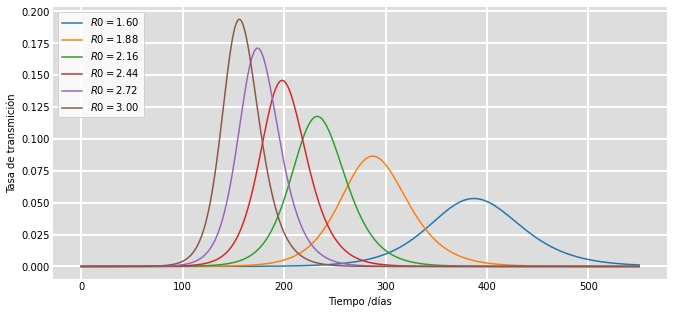

In [ ]:
def plot_rutas(rutas, labels, tiempo=t_vec):

    fig = plt.figure(facecolor='w',figsize=(11,5))
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    for ruta, label in zip(rutas, labels):
        ax.plot(tiempo, ruta, label=label)

    ax.set_xlabel('Tiempo /días')
    ax.set_ylabel('Tasa de transmición')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5) 
    ax.legend(loc='upper left')
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show()

plot_rutas(i_rutas,labels)

Como era de esperar, las tasas de transmisión efectivas más bajas retrasan el pico de infecciones.

También conducen a un pico más bajo en los casos actuales.

A continuación, se muestran casos acumulativos, como una fracción de la población:

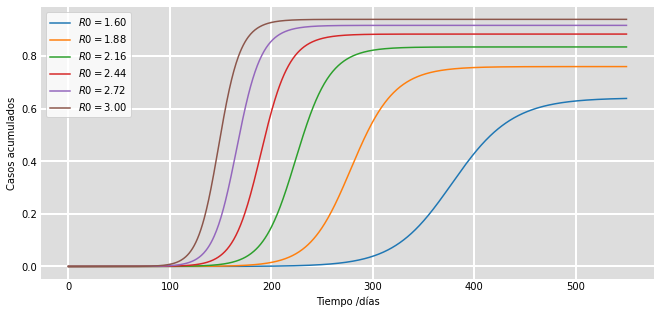

In [ ]:
def plot_rutasc(rutas, labels, tiempo=t_vec):

    fig = plt.figure(facecolor='w',figsize=(11,5))
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    for ruta, label in zip(rutas, labels):
        ax.plot(tiempo, ruta, label=label)

    ax.set_xlabel('Tiempo /días')
    ax.set_ylabel('Casos acumulados')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5) 
    ax.legend(loc='upper left')
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show()

plot_rutasc(c_rutas, labels)